In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import Progbar
from transformers import AutoTokenizer
from tensorflow.keras import backend as K

import numpy as np
import requests
import io
import pandas as pd
import string

from tqdm import tqdm
from PIL import Image

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 # Change this value as per requirement
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [ ]:
image_shape = (100, 100, 3)


def download_image_buffer(url):
    img = None
    try:
        data = requests.get(url,headers={"user-agent": "I am a valid user, please give me image"}).content
        img = Image.open(io.BytesIO(data))
        img = img.resize(image_shape[:2])
        img = np.array(img, dtype=np.float64)/255
    except:
        pass
    
    return img


def load_img(path, shape):
    img = keras.utils.load_img(path, color_mode="rgb")
    img = img.resize(shape)
    return np.array(img, dtype=np.float64)/255


learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
image_size = 100 
patch_size = 5 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
sequence_length = 128
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
vocab_size = tokenizer.vocab_size

In [ ]:
image_files = os.listdir("./datasets/conceptual-12m/images")
image_idx = [int(item.split(".")[0]) for item in tqdm(image_files)]

In [ ]:
with open("./datasets/conceptual-12m/cc12m.tsv", "r", encoding="utf-8") as dataset_file:    
    urls, texts = [], []

    file_idx = 0

    for idx in tqdm(sorted(image_idx)):
        while file_idx != idx:
            file_idx += 1

        item = next(dataset_file)
        url, text = item.split("\t")
        texts.append(text.replace("\n", ""))

In [ ]:
captions = texts

In [ ]:
image_files = np.array(image_files, dtype=str)
captions = np.array(captions, dtype=str)

base_dir = "./datasets/conceptual-12m/images/"

In [ ]:
def preprocess(path, text):
    path = path.numpy().decode('utf-8')
    text = text.numpy().decode('utf-8')

    img = load_img(base_dir + path, image_shape[:2])
    tokenized_text = np.array(tokenizer.encode(text, max_length=sequence_length, add_special_tokens=True, padding="max_length", truncation=True))

    return img, tokenized_text

def dict_map(img, tokenized_text):
    return ({
        "image": img,
        "text": tokenized_text[:-1]
    }, tokenized_text[1:])

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        self._input = images
        batch_size = tf.shape(images)[0]
        patches_tensor = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches_tensor.shape[-1]  # Dimension of each patch

        patches_tensor = tf.reshape(patches_tensor, [batch_size, self.num_patches, patch_dims])
        return patches_tensor

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        self._input = inputs
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [ ]:
class EncoderBlock(layers.Layer):
    def __init__(self, num_heads, embedding_dims, hidden_layers, hidden_units="same", attn_dropout=0.2, ff_dropout=0.2, **kwargs):
        super().__init__(**kwargs)

        self.num_heads = num_heads
        self.embedding_dims = embedding_dims
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units if hidden_units != "same" else embedding_dims
        self.attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=attn_dropout
        )
        self.attn_norm = layers.LayerNormalization()
        self.ff = []

        for _ in range(hidden_layers):
            self.ff.append(layers.Dense(
                self.hidden_units,
                activation=tf.nn.gelu
            ))
            self.ff.append(layers.Dropout(ff_dropout))

        self.ff = keras.Sequential(self.ff)
        self.ff_norm = layers.LayerNormalization()
    
    def call(self, inputs, mask=None):
        attn_output = self.attn(
            query=inputs,
            key=inputs,
            value=inputs
        )

        attn_output_norm = self.attn_norm(inputs + attn_output)

        x = self.ff(attn_output_norm)
        
        ff_output = self.ff_norm(attn_output + x)
        
        return {
            "ff_output": ff_output,
            "attn_output": attn_output
        }

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embedding_dim": self.embedding_dims,
                "num_heads": self.num_heads,
                "ff_hidden_layers": self.hidden_layers,
                "ff_hidden_units": self.hidden_units
            }
        )
        return config

In [ ]:
class DecoderBlock(layers.Layer):
    def __init__(self, 
                 num_heads_self, 
                 embedding_dims_self, 
                 hidden_layers, 
                 hidden_units="same", 
                 num_heads_cross="same", 
                 embedding_dims_cross="same", 
                 attn_dropout=0.2, 
                 ff_dropout=0.2, **kwargs):
        super().__init__(**kwargs)

        self.num_heads = num_heads
        self.embedding_dims = embedding_dims_self
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units if hidden_units != "same" else embedding_dims_self
        self.num_heads_cross = num_heads_cross if num_heads_cross != "same" else num_heads_self
        self.embedding_dims_cross = embedding_dims_cross if embedding_dims_cross != "same" else embedding_dims_self

        self.self_attn = layers.MultiHeadAttention(
            num_heads=num_heads_self, 
            key_dim=embedding_dims_self,
            dropout=attn_dropout,
            name="Self-attn-decoder"
        )
        self.self_norm = layers.LayerNormalization()

        self.cross_attn = layers.MultiHeadAttention(
            num_heads=self.num_heads_cross, 
            key_dim=self.embedding_dims_cross,
            dropout=attn_dropout,
            name="cross-attn-decoder"
        )
        self.cross_norm = layers.LayerNormalization()
        
        self.ff = []

        for _ in range(hidden_layers):
            self.ff.append(layers.Dense(
                self.hidden_units,
                activation=tf.nn.gelu
            ))
            self.ff.append(layers.Dropout(ff_dropout))

        self.ff = keras.Sequential(self.ff)
        self.ff_norm = layers.LayerNormalization()
        self.add = layers.Add()  # instead of `+` to preserve mask
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        self_attn_output = self.self_attn(
            query=inputs, key=inputs, value=inputs, use_causal_mask=True
        )
        self_attn_output = self.self_norm(self.add([inputs, self_attn_output]))

        cross_attn_output = self.cross_attn(
            query=self_attn_output, key=encoder_outputs, value=encoder_outputs,
        )
        cross_attn_output = self.cross_norm(self.add([self_attn_output, cross_attn_output]))

        ff_output = self.ff(cross_attn_output)
        ff_output = self.ff_norm(self.add([ff_output, cross_attn_output]))

        return ff_output
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embedding_dim": self.embedding_dims,
                "embedding_dim_cross": self.embedding_dims_cross,
                "num_heads": self.num_heads,
                "num_heads_cross": self.num_heads_cross,
                "ff_hidden_layers": self.hidden_layers,
                "ff_hidden_units": self.hidden_units
            }
        )
        return config

In [ ]:
num_blocks_encoder = 2
num_blocks_decoder = 2
num_heads = 16
embedding_dims = 128
hidden_layers = 2
text_embedding_dims = 256
projection_dim = 128

In [ ]:
image_input = layers.Input(shape=image_shape, name="image")
patches = Patches(patch_size, num_patches, name="patches")(image_input)
encoded_patches = PatchEncoder(num_patches, projection_dim, name="patch_encoder")(patches)

caption_input = layers.Input(shape=(sequence_length-1), name="text")
encoded_captions = PositionalEmbedding(sequence_length, vocab_size, embedding_dims, name="caption_encoder")(caption_input)


for _ in range(num_blocks_encoder):
    encoded_patches = EncoderBlock(
        num_heads,
        embedding_dims,
        hidden_layers
    )(encoded_patches)["ff_output"]


for _ in range(num_blocks_decoder):
    encoded_captions = DecoderBlock(
        num_heads,
        embedding_dims,
        hidden_layers
    )(encoded_captions, encoded_patches)

top_layer = layers.Dense(1024, activation=tf.nn.gelu)(encoded_captions)
top_layer = layers.Dense(vocab_size, activation=tf.nn.softmax)(top_layer)

test_model = Model(inputs=[image_input, caption_input], outputs=top_layer)

In [ ]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.

    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.

    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.

    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.

    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))


In [ ]:
batch_size = 32

dataset = (tf.data.Dataset.from_tensor_slices((image_files, captions))
           .shuffle(1000)
           .map(lambda filepath, caption: tf.py_function(preprocess, [filepath, caption], [tf.float64, tf.int32]))
           .map(dict_map)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

In [ ]:
consine_restart_schedule = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate = 0.005,first_decay_steps = 500,alpha=0.1)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoints/",
    save_weights_only=True,
    monitor='loss',
    save_best_only=True,
    save_freq='epoch'
)

test_model.compile(
    keras.optimizers.AdamW(learning_rate=consine_restart_schedule),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", keras.metrics.SparseTopKCategoricalAccuracy(k=20, name="top_20_accuracy"), keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top_10_error"), keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5_error")],
)
test_model.summary()

In [ ]:
progbar = Progbar(len(dataset))

_callbacks = [checkpoint_callback]
callbacks = tf.keras.callbacks.CallbackList(
    _callbacks, add_history=True, model=test_model)

logs = {}
callbacks.on_train_begin(logs=logs)

for i in range(num_epochs):
    dataset_iter = dataset.as_numpy_iterator()

    callbacks.on_epoch_begin(i, logs=logs)

    for step in range(len(dataset)):

        batch_input, target = dataset_iter.next()
        # callbacks.on_batch_begin(batch_input, logs=logs)

        result = test_model.train_on_batch(batch_input, y=target, return_dict=True)

        loss = result["loss"]
        accuracy = result['accuracy']
        # top_20 = result['top_20_error']

        logs = result

        progbar.update(step + 1, [(k, v) for k,v in result.items()])
        # callbacks.on_batch_end(batch_input, logs=logs)

    callbacks.on_epoch_end(i, logs=logs)

callbacks.on_train_end(logs=logs)


In [59]:
test_model.save_weights("./model_weights/first.h5")

# Sampling

In [64]:
from PIL import Image
from random import randint

import matplotlib.pyplot as plt

In [86]:
sample_idx = randint(0, len(image_files))

3267: 2020 the one where erica turned 40 and was quarantined shirt


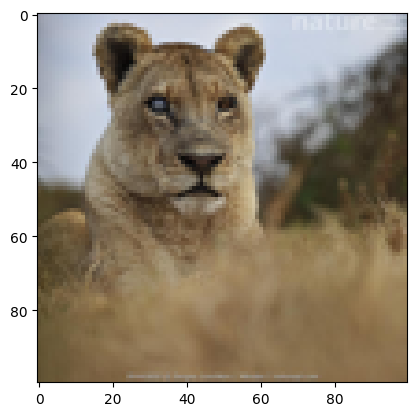

In [89]:
image = load_img("./datasets/conceptual-12m/images/"+image_files[sample_idx], (100, 100))
caption = captions[sample_idx]

print(f"{sample_idx}: {caption}")
plt.imshow(image)